ROC AUC por fold: [0.95854586 0.96050238 0.96241649 0.94747974 0.95811872]
Promedio ROC AUC: 0.9574126362915057

Reporte de clasificación:

              precision    recall  f1-score   support

No Detractor       0.94      0.85      0.89       360
   Detractor       0.97      0.99      0.98      1973

    accuracy                           0.97      2333
   macro avg       0.96      0.92      0.94      2333
weighted avg       0.97      0.97      0.97      2333



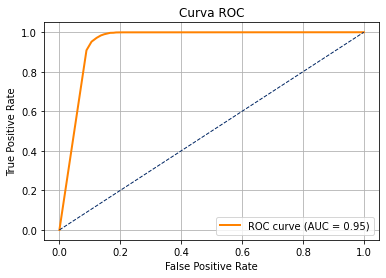

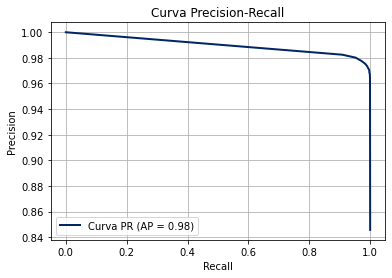

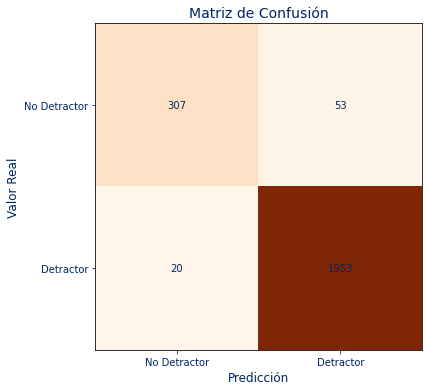

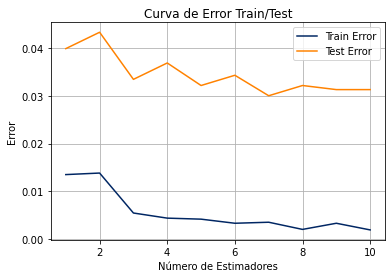

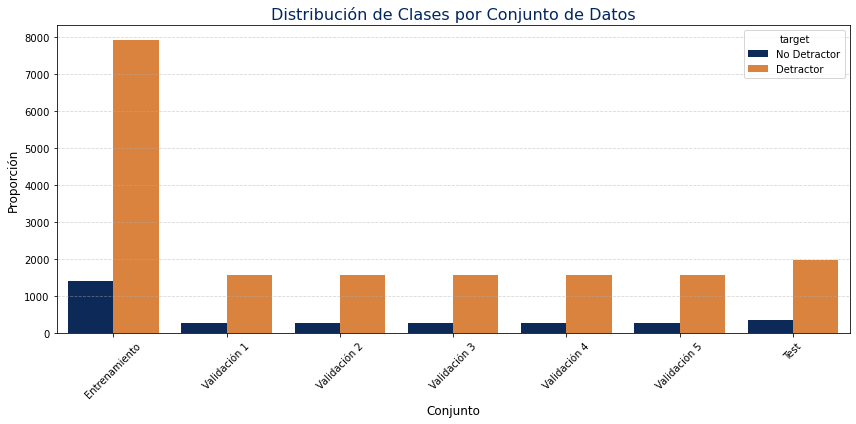

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             roc_curve, auc, precision_recall_curve, 
                             average_precision_score)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, classification_report


azul_itaú = "#002663"
naranja_itaú = "#FF8200"

# Leer datos
df = pd.read_csv('base_final_EDA.csv')
x = df.drop(['detractor'], axis=1)
y = df['detractor']



x, y = make_classification(n_samples=11662, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=2,
                           n_clusters_per_class=1,
                           weights=[0.15, 0.85], class_sep=0.8,
                           random_state=0)

# Train/Test split
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                   random_state=130, 
                                   test_size=0.20, 
                                   shuffle=True)





# Clasificador
model = BaggingClassifier(DecisionTreeClassifier(), random_state=0)

# Validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(model, x_train, y_train, cv=cv, scoring='roc_auc')
print("ROC AUC por fold:", scores)
print("Promedio ROC AUC:", scores.mean())

# Entrenamiento final y predicciones
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_proba = model.predict_proba(x_test)[:, 1]

labels = ['No Detractor', 'Detractor']

print("\nReporte de clasificación:\n")
print(classification_report(y_test, y_pred, target_names=labels))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='#FF8200', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='#002663', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

plt.figure()
plt.plot(recall, precision, color='#002663', lw=2, label='Curva PR (AP = %0.2f)' % ap)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


# === MATRIZ DE CONFUSIÓN ===
cm = confusion_matrix(y_test, y_pred)
labels = ['No Detractor', 'Detractor']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.get_cmap('Oranges'), colorbar=False)

plt.title("Matriz de Confusión", fontsize=14, color='#002663')
plt.xlabel("Predicción", fontsize=12)
plt.ylabel("Valor Real", fontsize=12)
for texts in [disp.text_]:
    for t in texts.flatten():
        t.set_color('#002663')
ax.xaxis.label.set_color('#002663')
ax.yaxis.label.set_color('#002663')
ax.tick_params(axis='x', colors='#002663')
ax.tick_params(axis='y', colors='#002663')
plt.tight_layout()
plt.show()


train_errors = []
test_errors = []

for n in range(1, model.n_estimators + 1):
    partial_model = BaggingClassifier(DecisionTreeClassifier(), n_estimators=n, random_state=0)
    partial_model.fit(x_train, y_train)
    train_error = 1 - partial_model.score(x_train, y_train)
    test_error = 1 - partial_model.score(x_test, y_test)
    train_errors.append(train_error)
    test_errors.append(test_error)

plt.figure()
plt.plot(range(1, model.n_estimators + 1), train_errors, label='Train Error', color=azul_itaú)
plt.plot(range(1, model.n_estimators + 1), test_errors, label='Test Error', color=naranja_itaú)
plt.xlabel('Número de Estimadores')
plt.ylabel('Error')
plt.title('Curva de Error Train/Test')
plt.legend()
plt.grid(True)
plt.show()
azul_itaú = "#002663"
naranja_itaú = "#FF8200"


# validamos clases en sub-sets
y_train_array = np.array(y_train)
y_test_array = np.array(y_test)

df_train = pd.DataFrame({'set': 'Entrenamiento', 'target': y_train_array})
df_test = pd.DataFrame({'set': 'Test', 'target': y_test_array})

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)
folds_data = []

for fold_idx, (_, val_index) in enumerate(cv.split(x_train, y_train), 1):
    val_targets = y_train_array[val_index]
    df_val = pd.DataFrame({'set': f'Validación {fold_idx}', 'target': val_targets})
    folds_data.append(df_val)

df_all = pd.concat([df_train] + folds_data + [df_test], ignore_index=True)

df_all['target'] = df_all['target'].map({0: 'No Detractor', 1: 'Detractor'})

# Gráfico de proporciones con countplot
plt.figure(figsize=(12, 6))
sns.countplot(data=df_all, x='set', hue='target', palette=['#002663', '#F48024'], 
              hue_order=['No Detractor', 'Detractor'])

plt.title('Distribución de Clases por Conjunto de Datos', fontsize=16, color='#002663')
plt.ylabel('Proporción', fontsize=12)
plt.xlabel('Conjunto', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()